# Prepare AutoSort

In this tutorial, we demonstrate how to train a AutoSort model with early-stage recordings and validate its performance.

For explanatory data analysis, we provide two days' recording on April 11th and April 16th, which can be downloaded here.

In [1]:
from autosort_neuron import *
import warnings
warnings.filterwarnings("ignore")

/n/holystore01/LABS/jialiu_lab/Users/yichunhe/AutoSort/autosort_neuron/sorting.py:19: DeprecationWarning: The 'toolkit' module is deprecated. Use spikeinterface.preprocessing/postptocessing/qualitymetrics instead
  import spikeinterface.toolkit as st


### Perform spike sorting with MountainSort and manual curation to get reference units

First, we need to define the geometry of the high-density probe

In [2]:
positions=np.array([
                [150, 250], ### electrode 1 x,y
                [150,200], ### electrode 2 x,y
                [50, 0], ### electrode 3 x,y
                [50, 50],
                [50, 100], 
                [0, 100],
                [0, 50], 
                [0, 0],
                [650, 0], 
                [650, 50],
                [650, 100], 
                [600, 100],
                [600, 50], 
                [600, 0],
                [500, 200],
                [500, 250],
                [500, 300],
                [450, 300],
                [450, 250], 
                [450, 200],
                [350, 400], 
                [350, 450],
                [350, 500], 
                [300, 500],
                [300, 450], 
                [300, 400], 
                [200, 200],
                [200, 250],
                [200, 300],
                [150, 300]
                    ])

(<matplotlib.collections.PolyCollection at 0x1519f4b63700>, None)

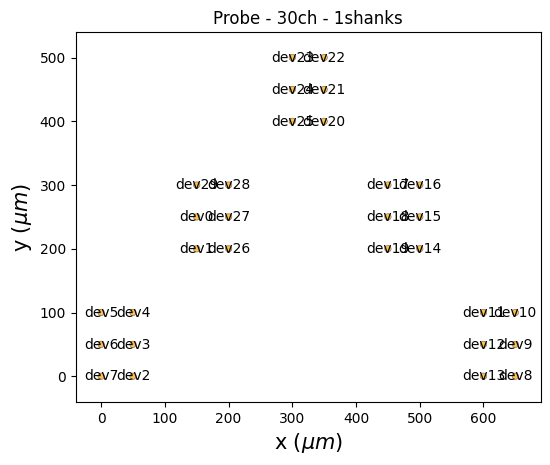

In [3]:
mesh_probe = create_mesh_probe(positions=positions,num_all_channels=positions.shape[0])
plot_probe(mesh_probe,with_device_index=True)

Next, we load raw data recorded through Intan system. We read two days' recording on 0305 and 0310, concatenate them.

In [4]:
### raw data path
raw_data_path = './raw_data/'

### file folder name to read
date_id_all=['0305','0310'] 
save_folder_name = '_'.join(date_id_all)

### processed data path
data_folder_all = f'./processed_data/Ephys_concat_{save_folder_name}/'


sorting_method="mountainsort"
sorting_save_path = data_folder_all + sorting_method + '/'


In [5]:
recording_concat, day_length = read_data_folder(data_folder_all, date_id_all, raw_data_path, mesh_probe, )

### bandpass filter and common reference

freq_max=3000
freq_min=300

recording_f = spikeinterface.preprocessing.bandpass_filter(recording_concat, freq_min=freq_min, 
                                                   freq_max=freq_max)
recording_cmr = spikeinterface.preprocessing.common_reference(recording_f, reference='global',operator='average')


BinaryFolderRecording: 30 channels - 1 segments - 10.0kHz - 399.386s
Num. channels = 30
Sampling frequency = 10000 Hz
Num. timepoints seg0= 1


We perform MountainSort spike sorting on the concatenated data.

In [6]:
if os.path.exists(sorting_save_path)==False:
    os.mkdir(sorting_save_path)
output_folder = sorting_save_path + '/sorting'
firing_save_path = output_folder + f'/firings.npz'      

In [7]:
default_params = {
        'detect_sign': -1,  # Use -1, 0, or 1, depending on the sign of the spikes in the recording
        'adjacency_radius': 120,  # Use -1 to include all channels in every neighborhood
        'freq_min': 300,  # Use None for no bandpass filtering
        'freq_max': 3000,
        'filter': True,
        'whiten': True,  # Whether to do channel whitening as part of preprocessing
        'num_workers': 9,
        'clip_size': 50,
        'detect_threshold': 4, # 5
        'detect_interval': 3,  # Minimum number of timepoints between events detected on the same channel, 30
    }

fs = 10000

In [8]:
if not os.path.exists(firing_save_path):
    sorting_wave_clus = ss.run_sorter(sorter_name='mountainsort4',
                                     recording=recording_cmr,
                                     remove_existing_folder='True',
                                     output_folder=output_folder,
                                     **default_params,)
    
    
    keep_unit_ids = []
    for unit_id in sorting_wave_clus.unit_ids:
        spike_train = sorting_wave_clus.get_unit_spike_train(unit_id=unit_id)
        n = spike_train.size
        if(n>20):
            keep_unit_ids.append(unit_id)

    curated_sorting = sorting_wave_clus.select_units(unit_ids=keep_unit_ids, renamed_unit_ids=None)
    NpzSortingExtractor.write_sorting(curated_sorting, firing_save_path)

sorting = se.NpzSortingExtractor(firing_save_path)

After spike sorting with MountainSort, we extract waveforms to manually curate units.

In [9]:
pack_folder = sorting_save_path
waveform_folder = pack_folder + 'waveforms'
# shutil.rmtree(waveform_folder)
we = spikeinterface.extract_waveforms(recording_cmr, sorting, waveform_folder,
    load_if_exists=True,
    ms_before=1, ms_after=2., max_spikes_per_unit=1000000,
    chunk_size=30000)

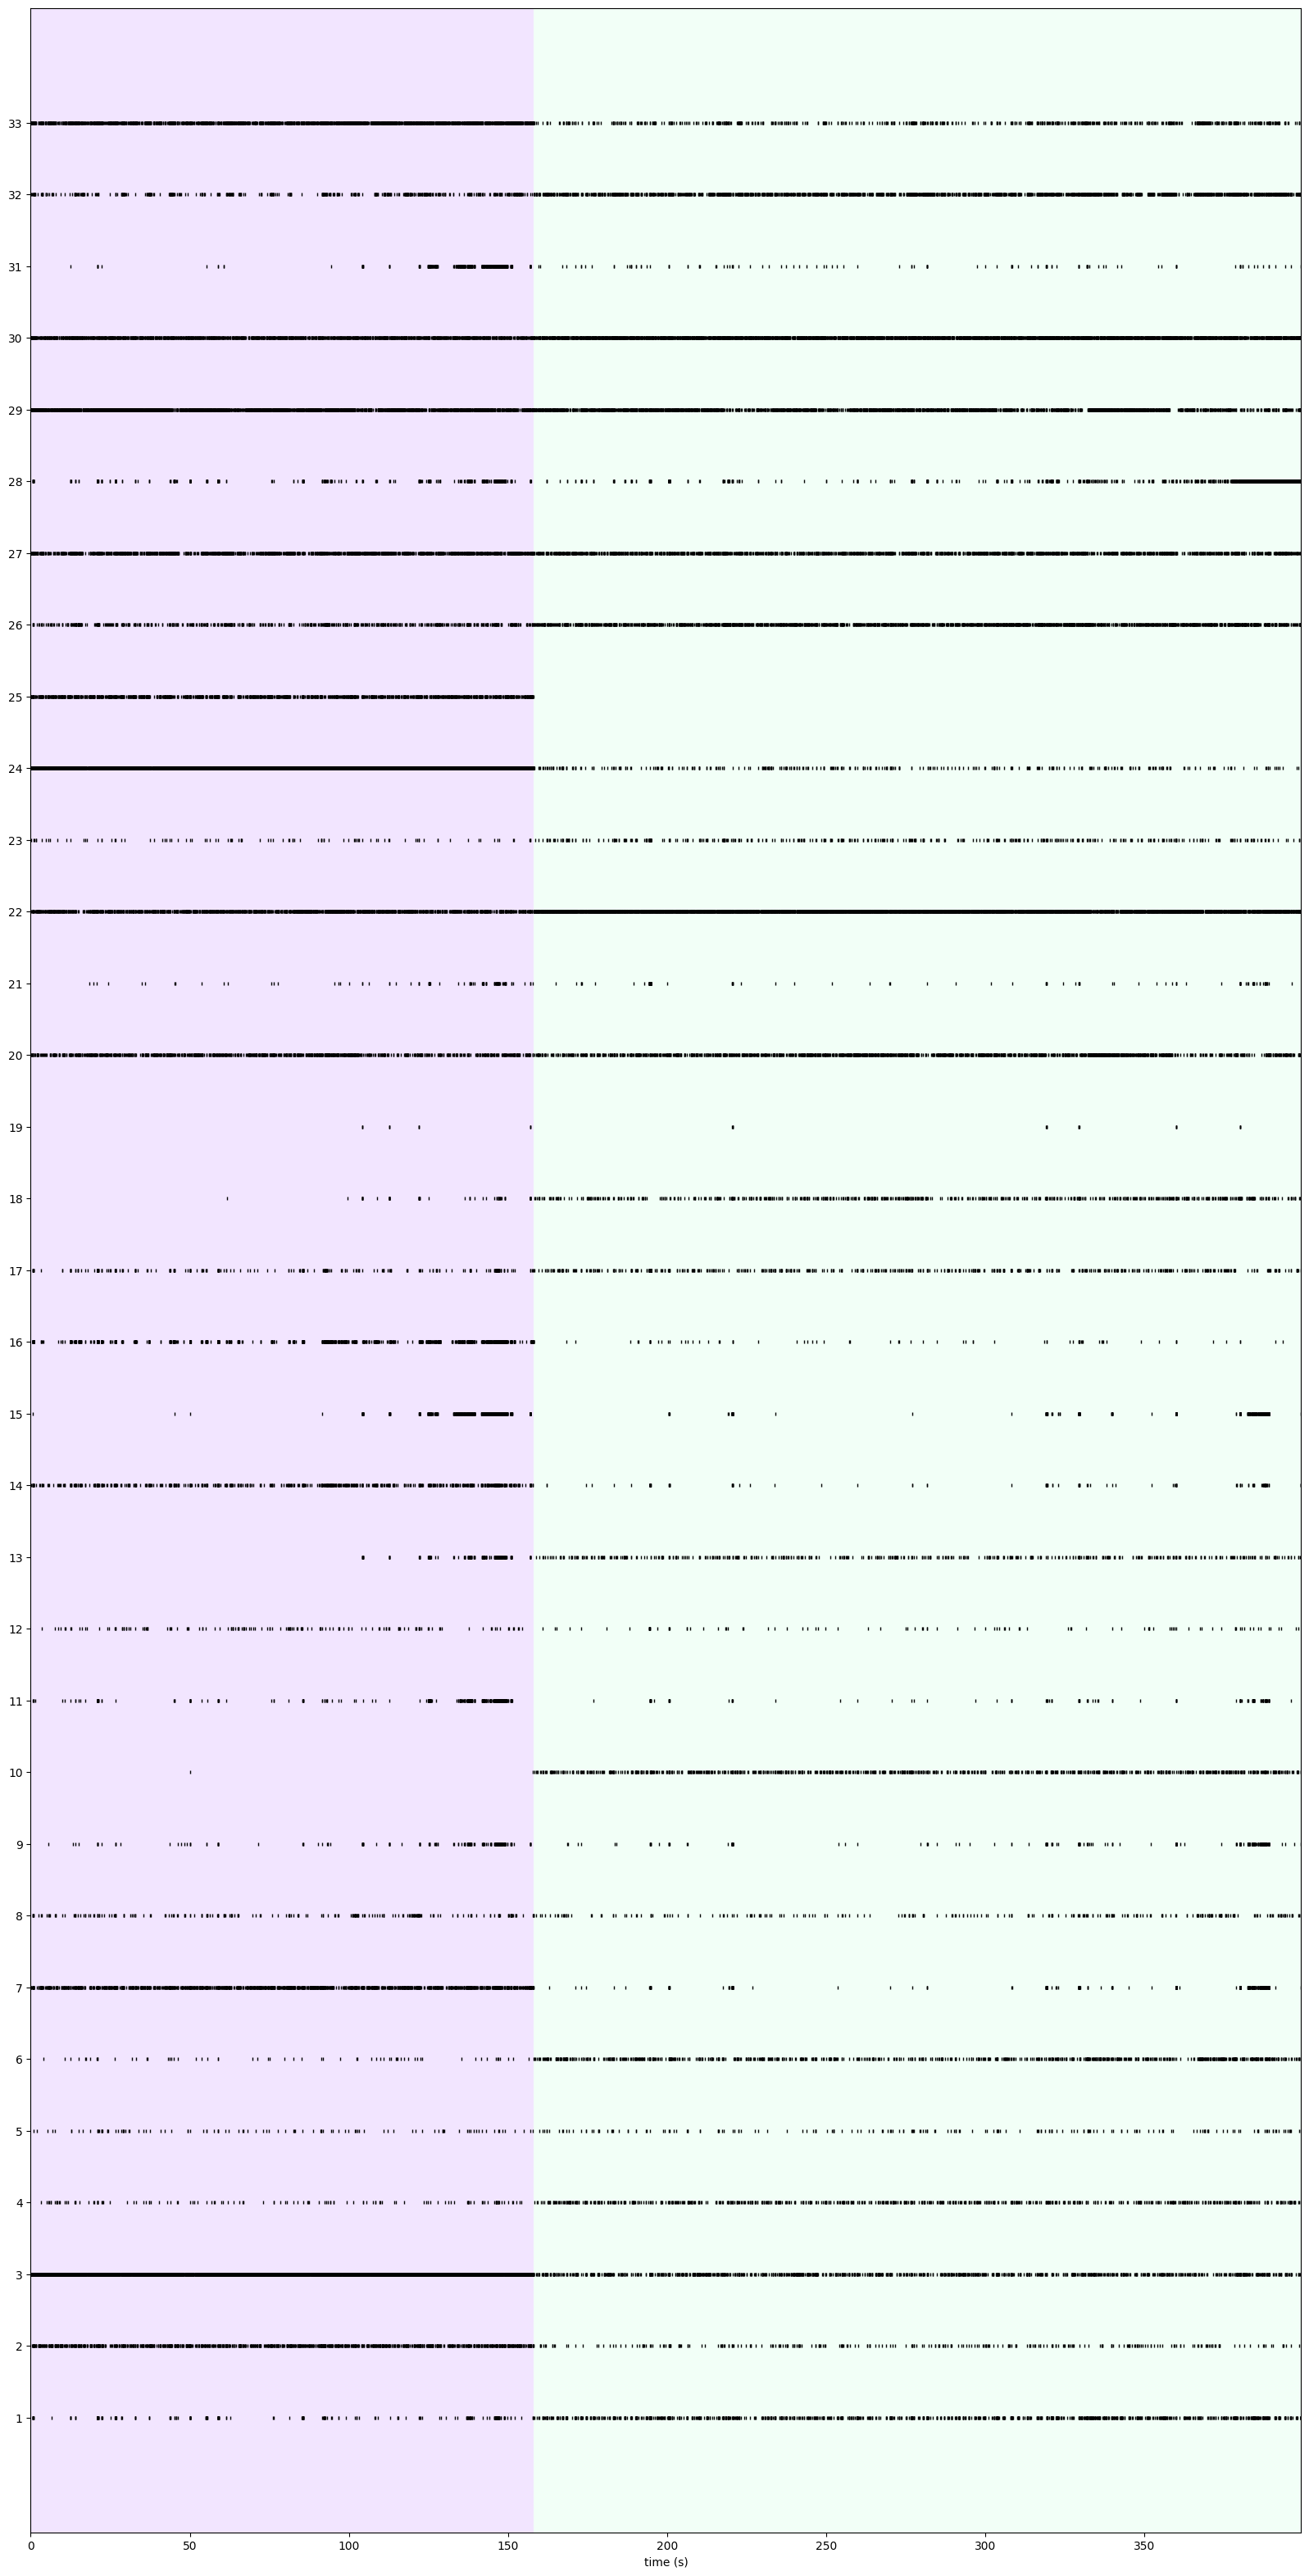

<Figure size 640x480 with 0 Axes>

In [10]:
we.recording.set_probe(mesh_probe, in_place=True)
sorting_day_split(sorting, date_id_all, day_length, pack_folder, 
                  sorting_save_name='firings_inlier')

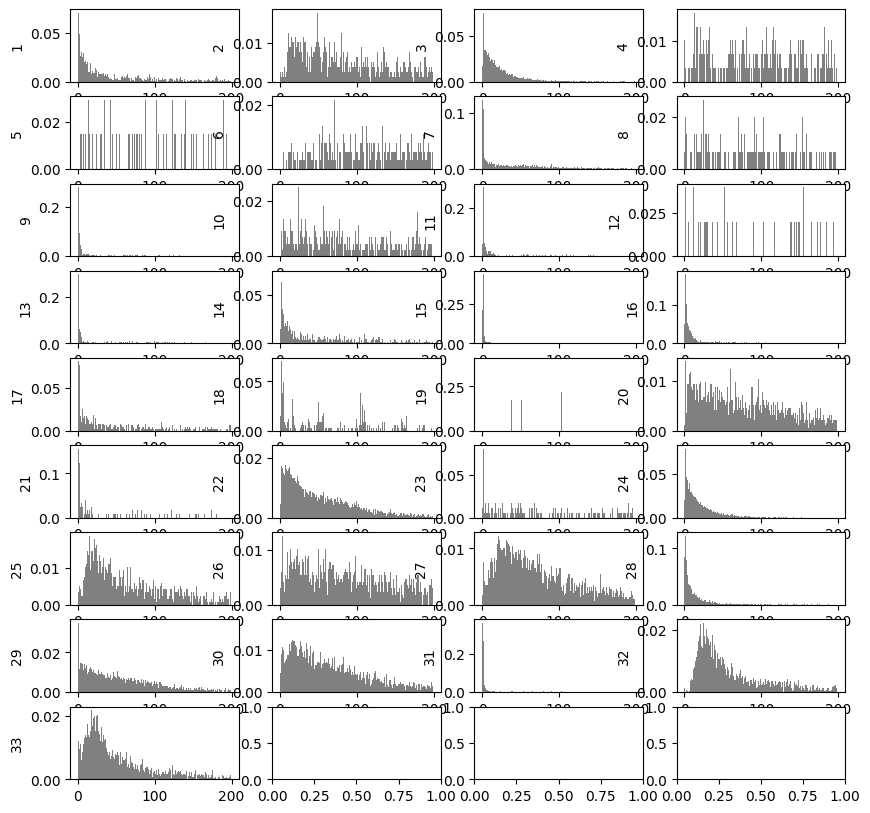

In [11]:
fig,ax = plt.subplots(int(ceil(sorting.unit_ids.shape[0]/4)),4,figsize=(10,10))
sw.plot_isi_distribution(sorting, window_ms=200.0, bin_ms=1.0,axes=ax)

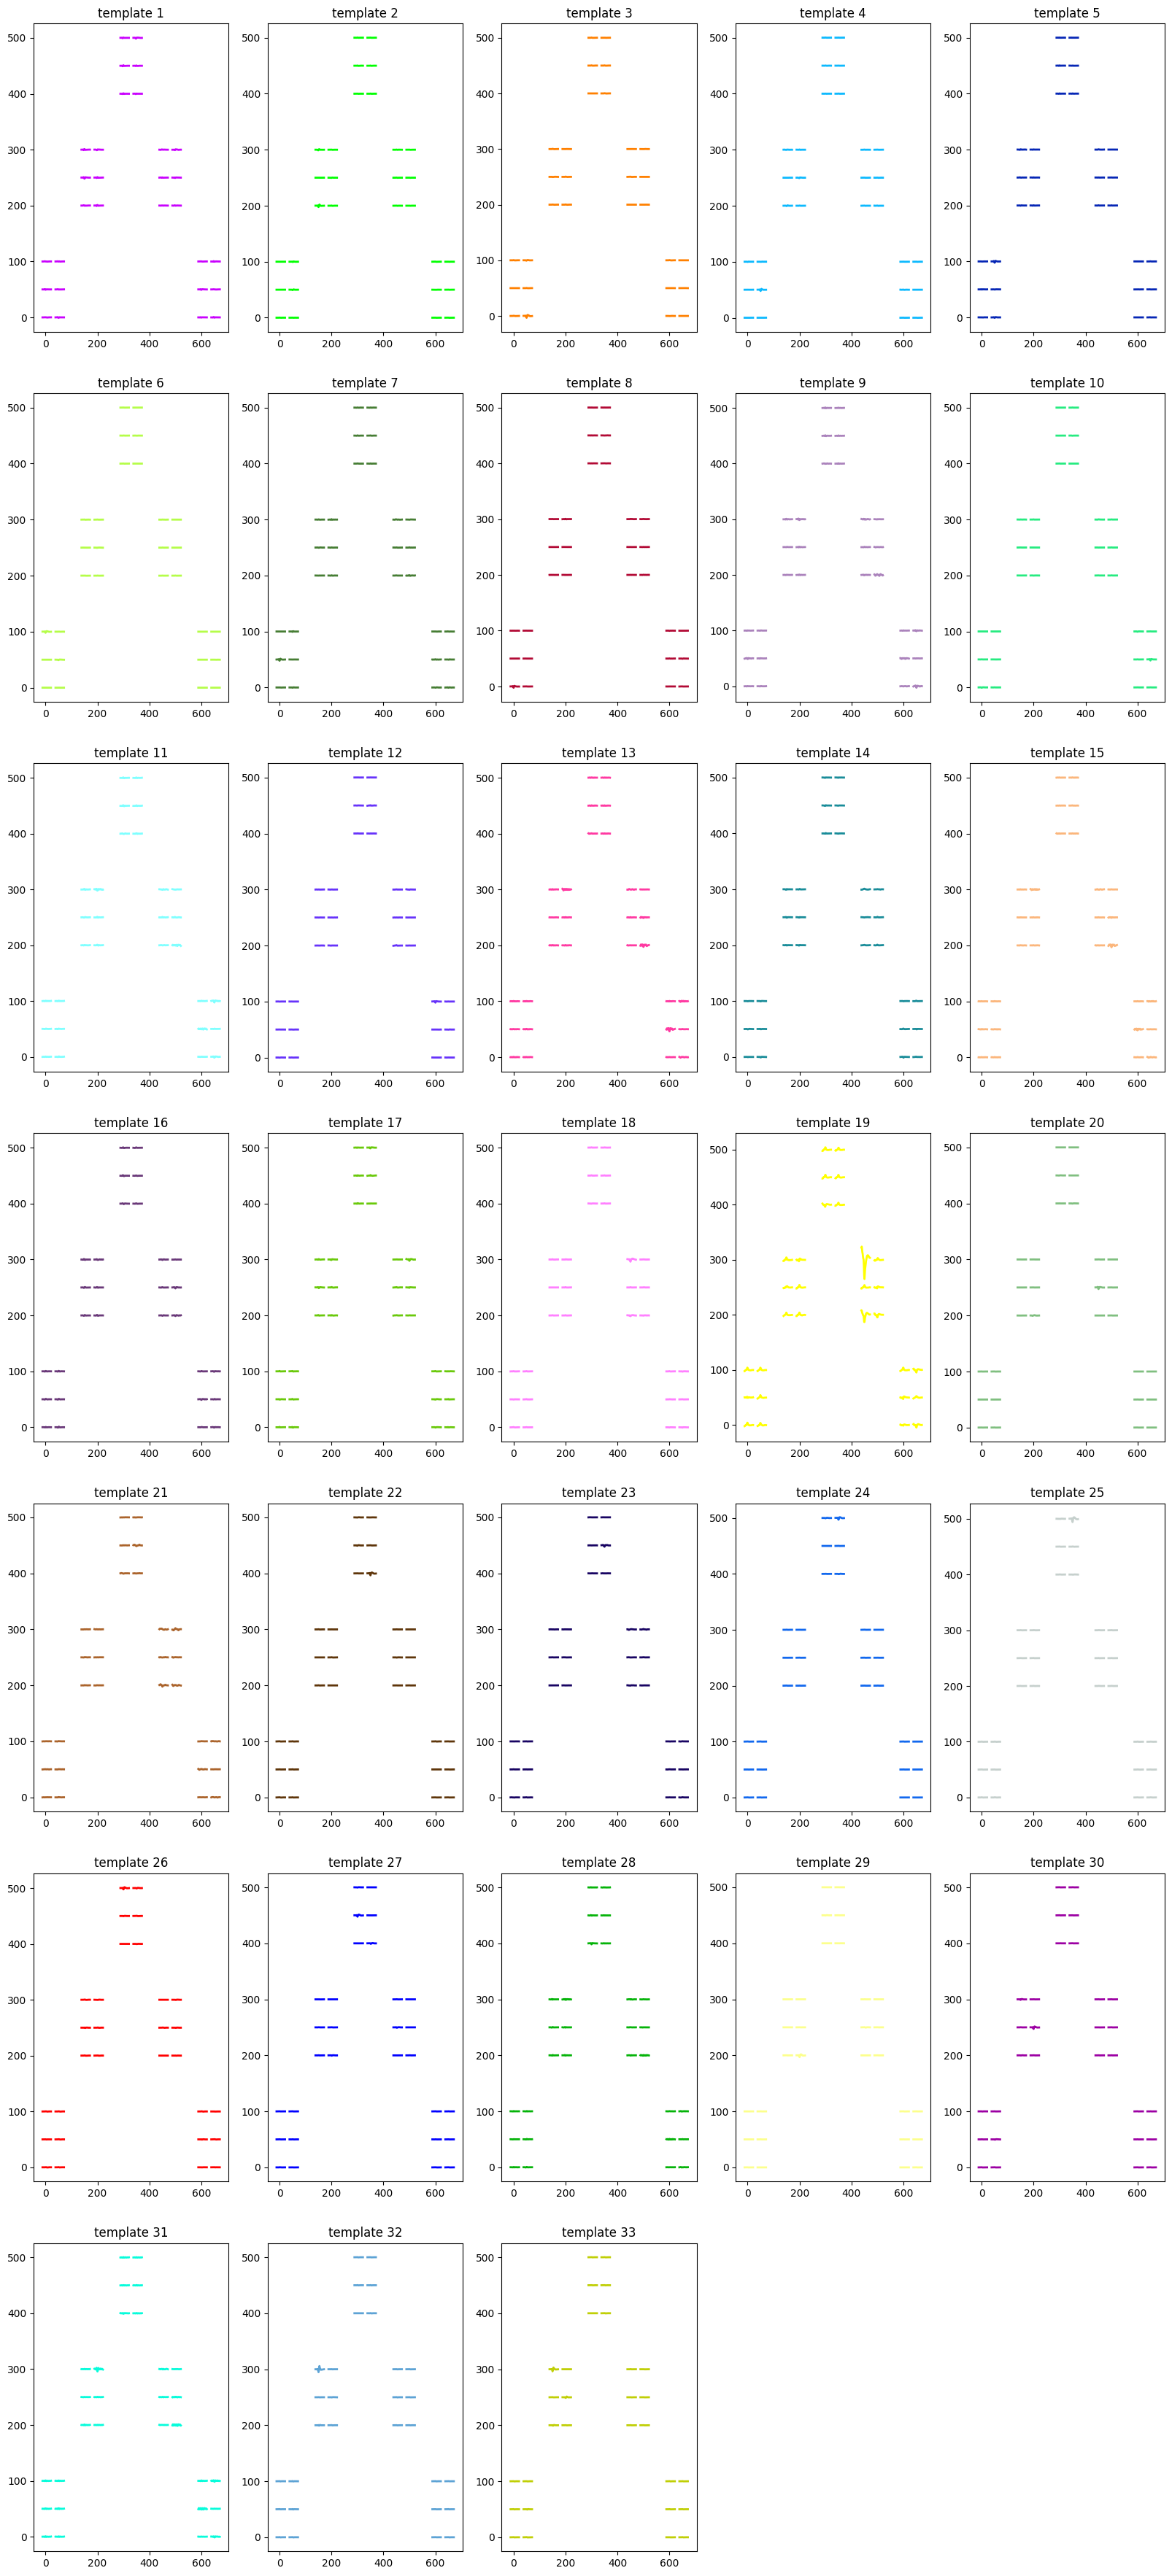

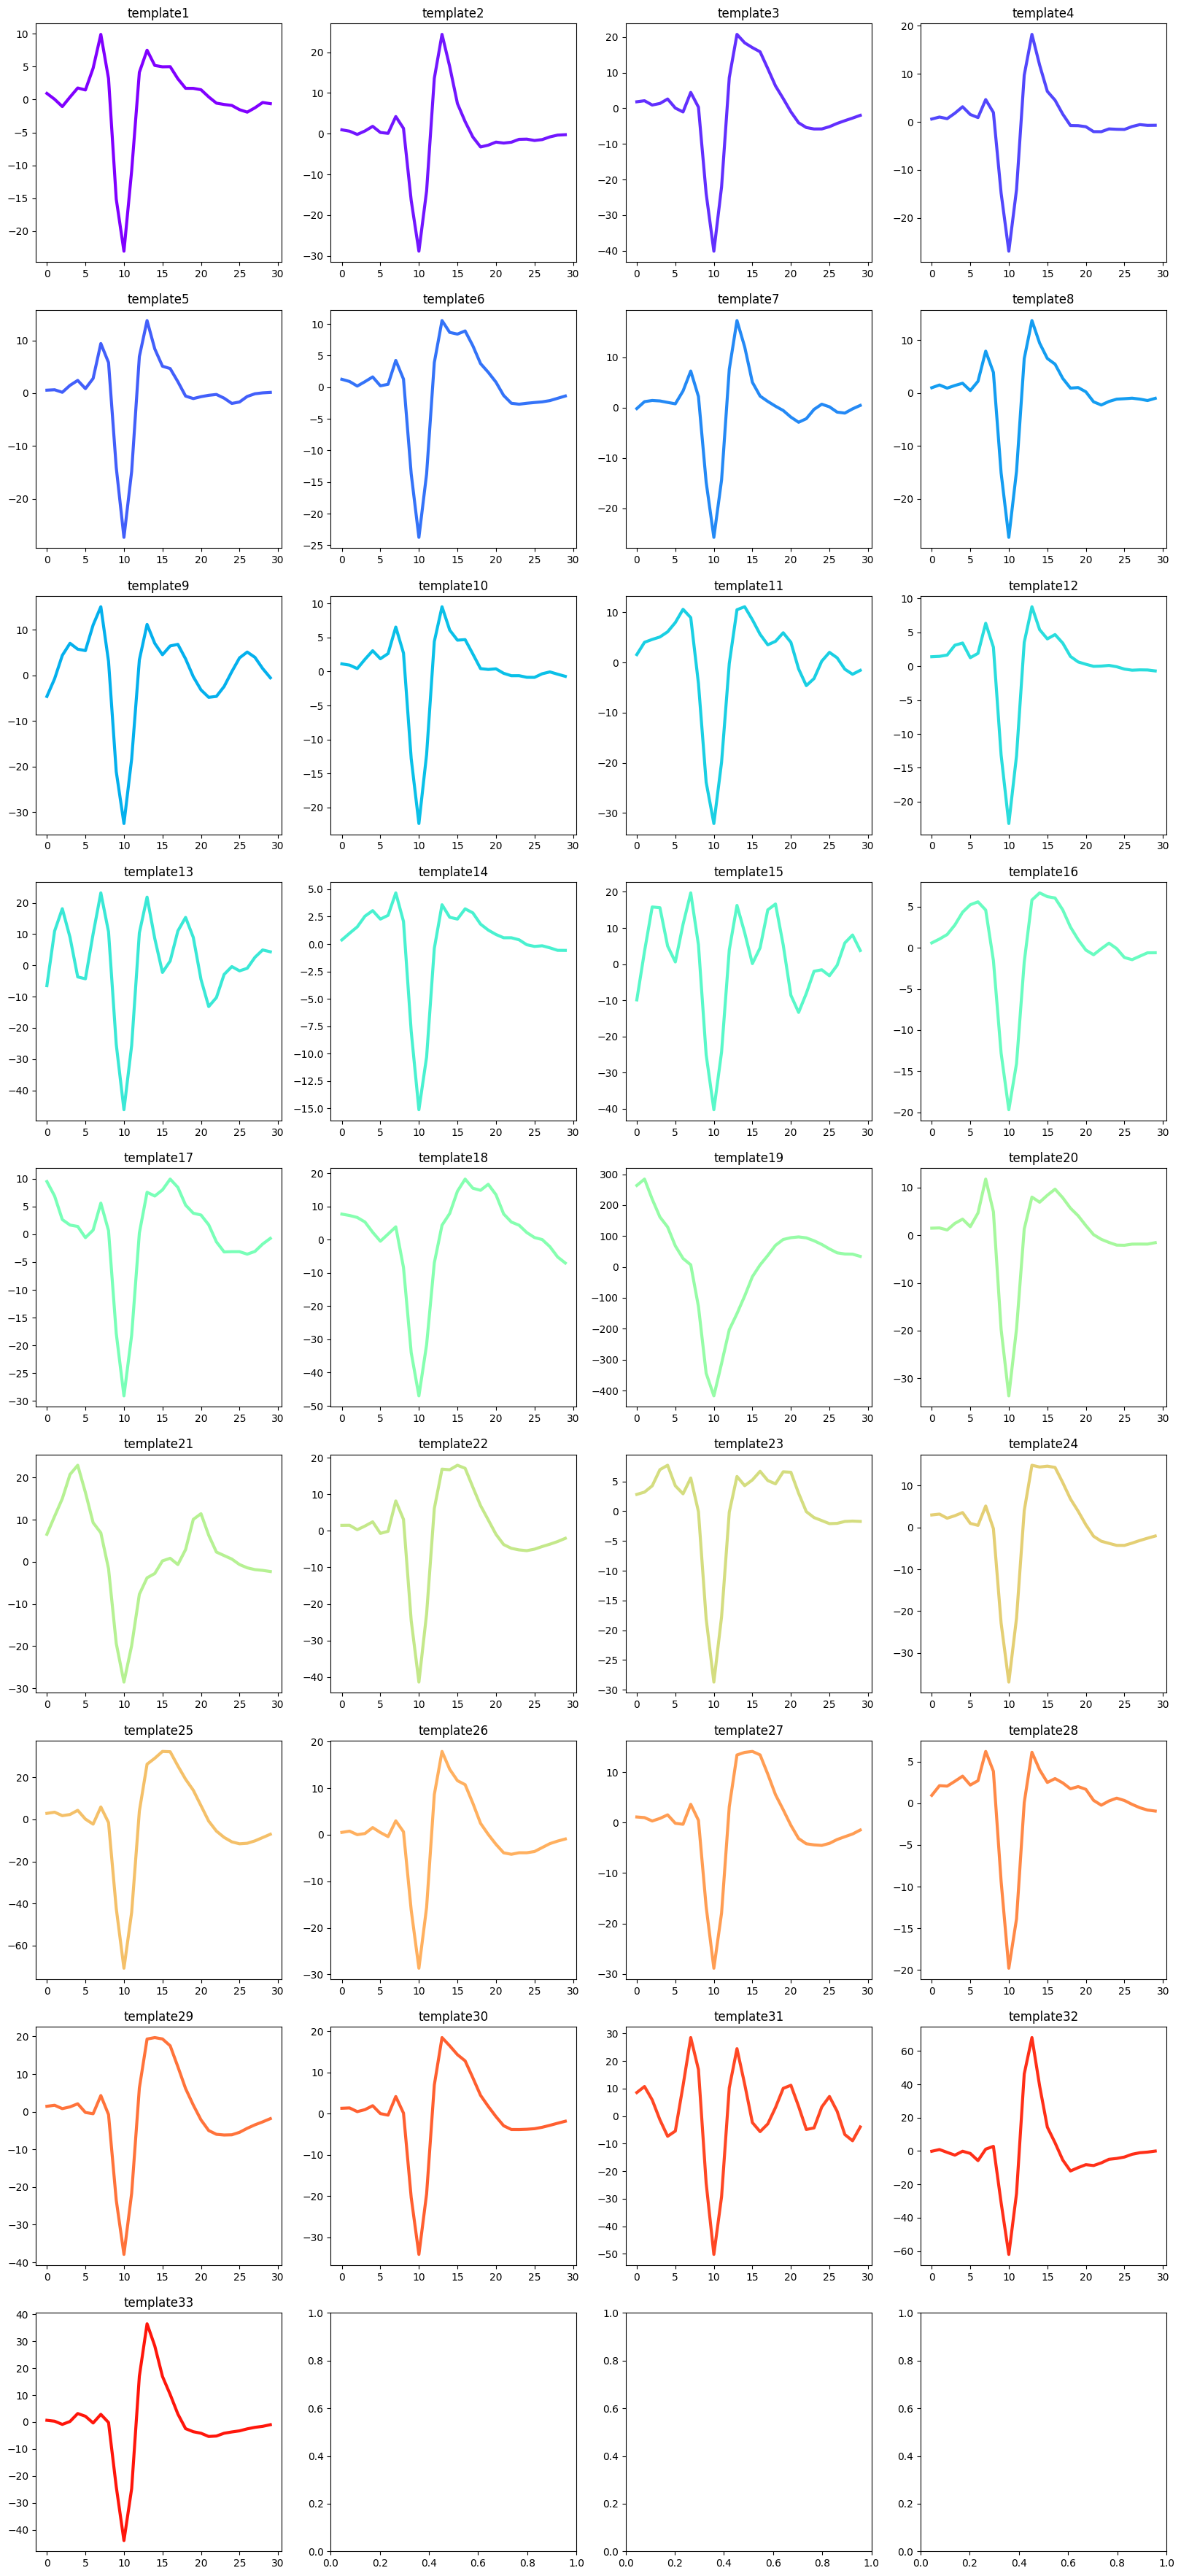

In [12]:
# we._template_cache={}
sorting_unit_show(we, recording_cmr, sorting, pack_folder,waveform_folder)

Through ISI, waveform characteristics and spiking patterns, we keep units ID 2,4,9,16,21,30,35,62,73,83,84,85,88,89,90,91,92,103.

In [13]:
x=list(np.arange(1,np.max(sorting.unit_ids)+1))
y=[2,3,4,6,7,8,10,18,22,24,25,26,27,29,30,32,33]
left = [item for item in x if item not in y]

merge_unit_ids_pack = [] 
delete_unit_ids_pack = left
we_load_if_exists = True
waveform_show = False
input_state = 'merged'

curation_save_folder = pack_folder + f'/curation_result_{input_state}/'
if os.path.exists(curation_save_folder)==False:
    os.mkdir(curation_save_folder)

sorting,we = units_merge(recording_cmr, sorting, merge_unit_ids_pack, delete_unit_ids_pack,pack_folder, True)

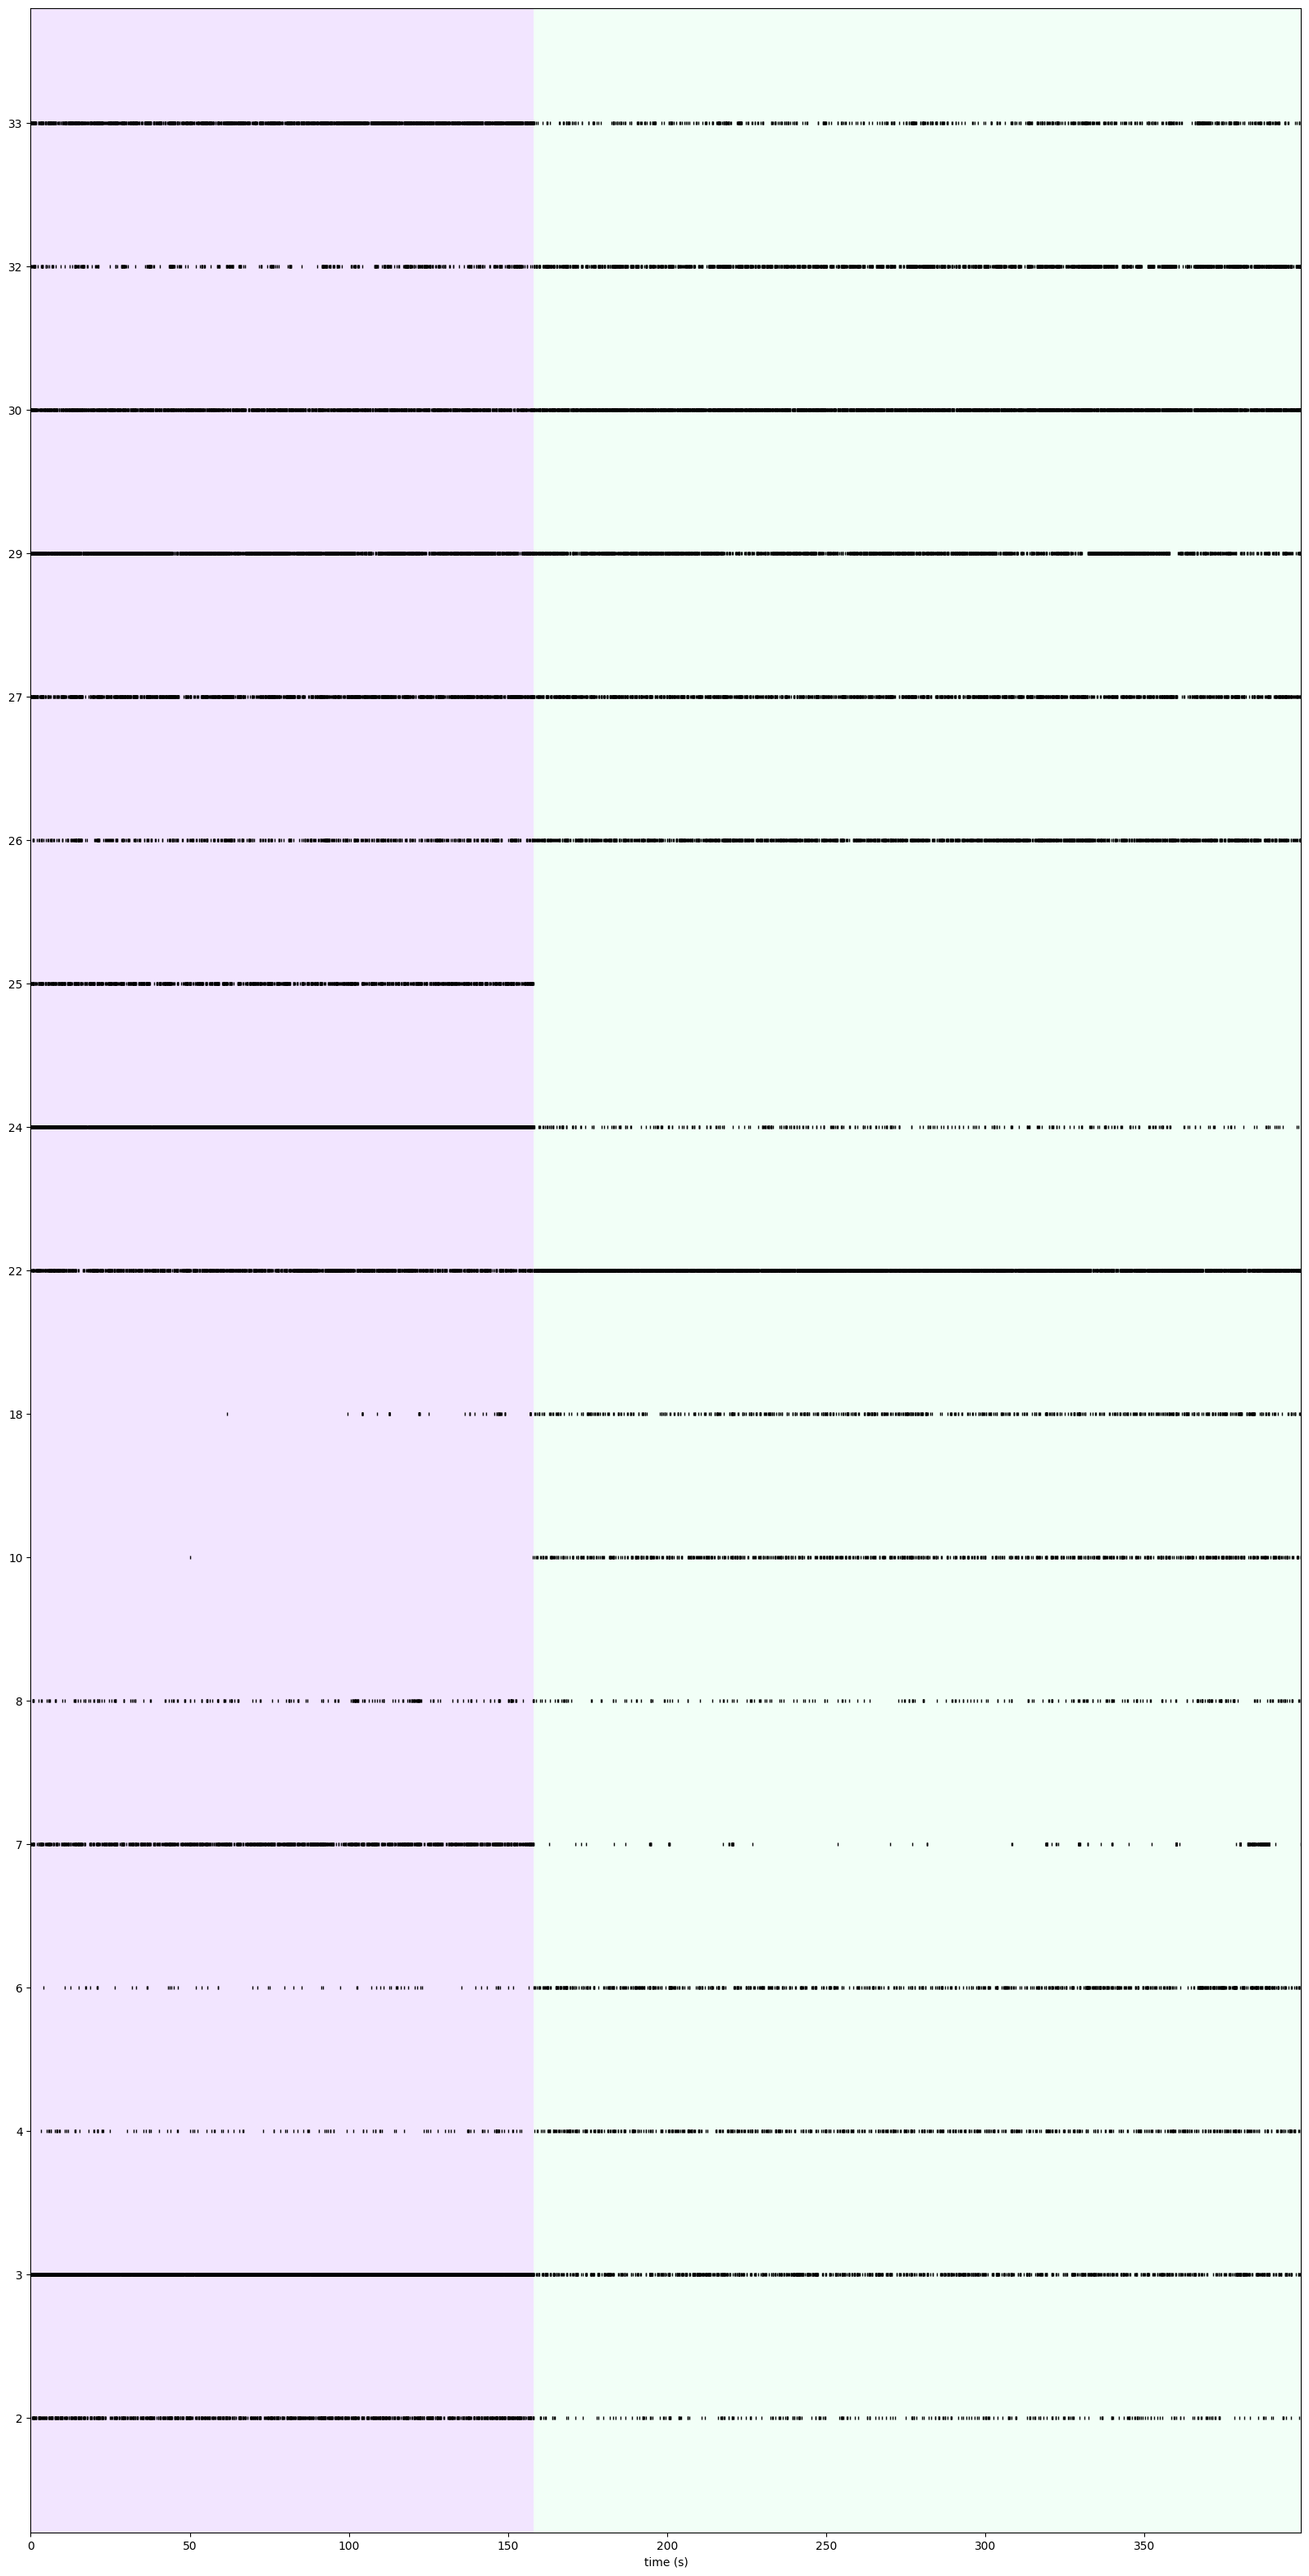

<Figure size 640x480 with 0 Axes>

In [14]:
sorting_day_split(sorting, date_id_all, day_length, pack_folder, 
                  sorting_save_name='firings_merged')

We extract waveforms and the extremum channel of curated units.

In [15]:
we._template_cache=[]
we.run_extract_waveforms()

probe_groups = np.arange(0,30)
NUmShanks = 30
we_load_if_exists = True

extremum_channels_ids = st.get_template_extremum_channel(we, peak_sign='neg')

pd.DataFrame.from_dict(extremum_channels_ids, orient='index').to_csv(pack_folder+'extremum_channels_ids.csv')

Plot waveforms and ISI of curated units.

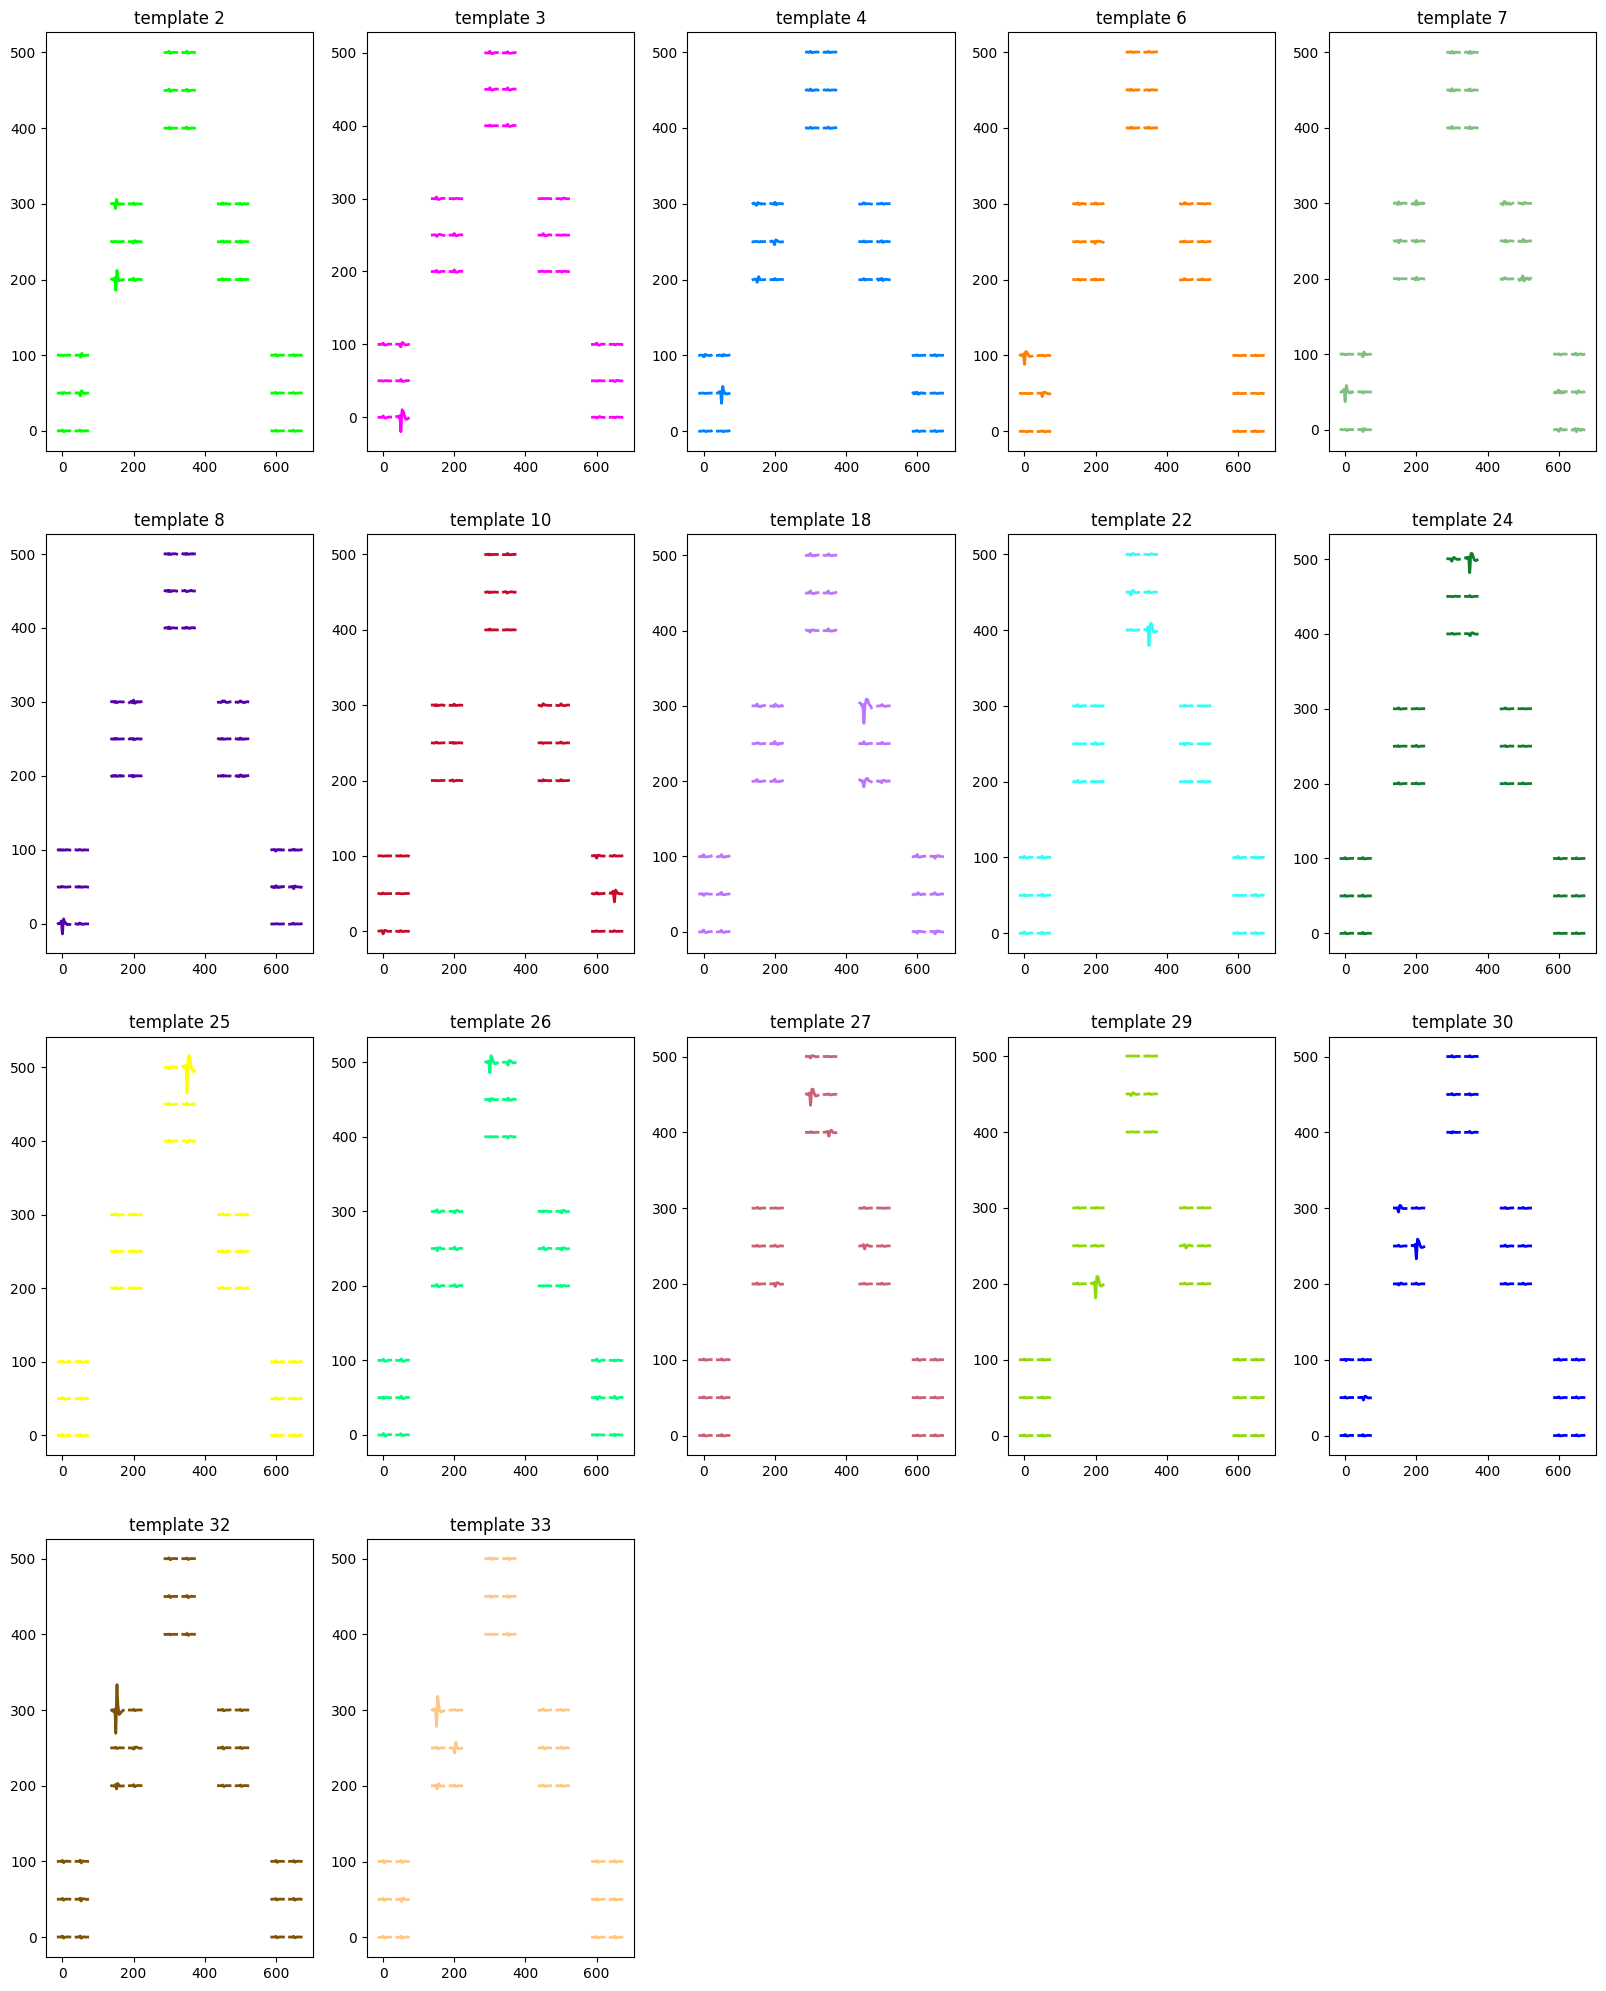

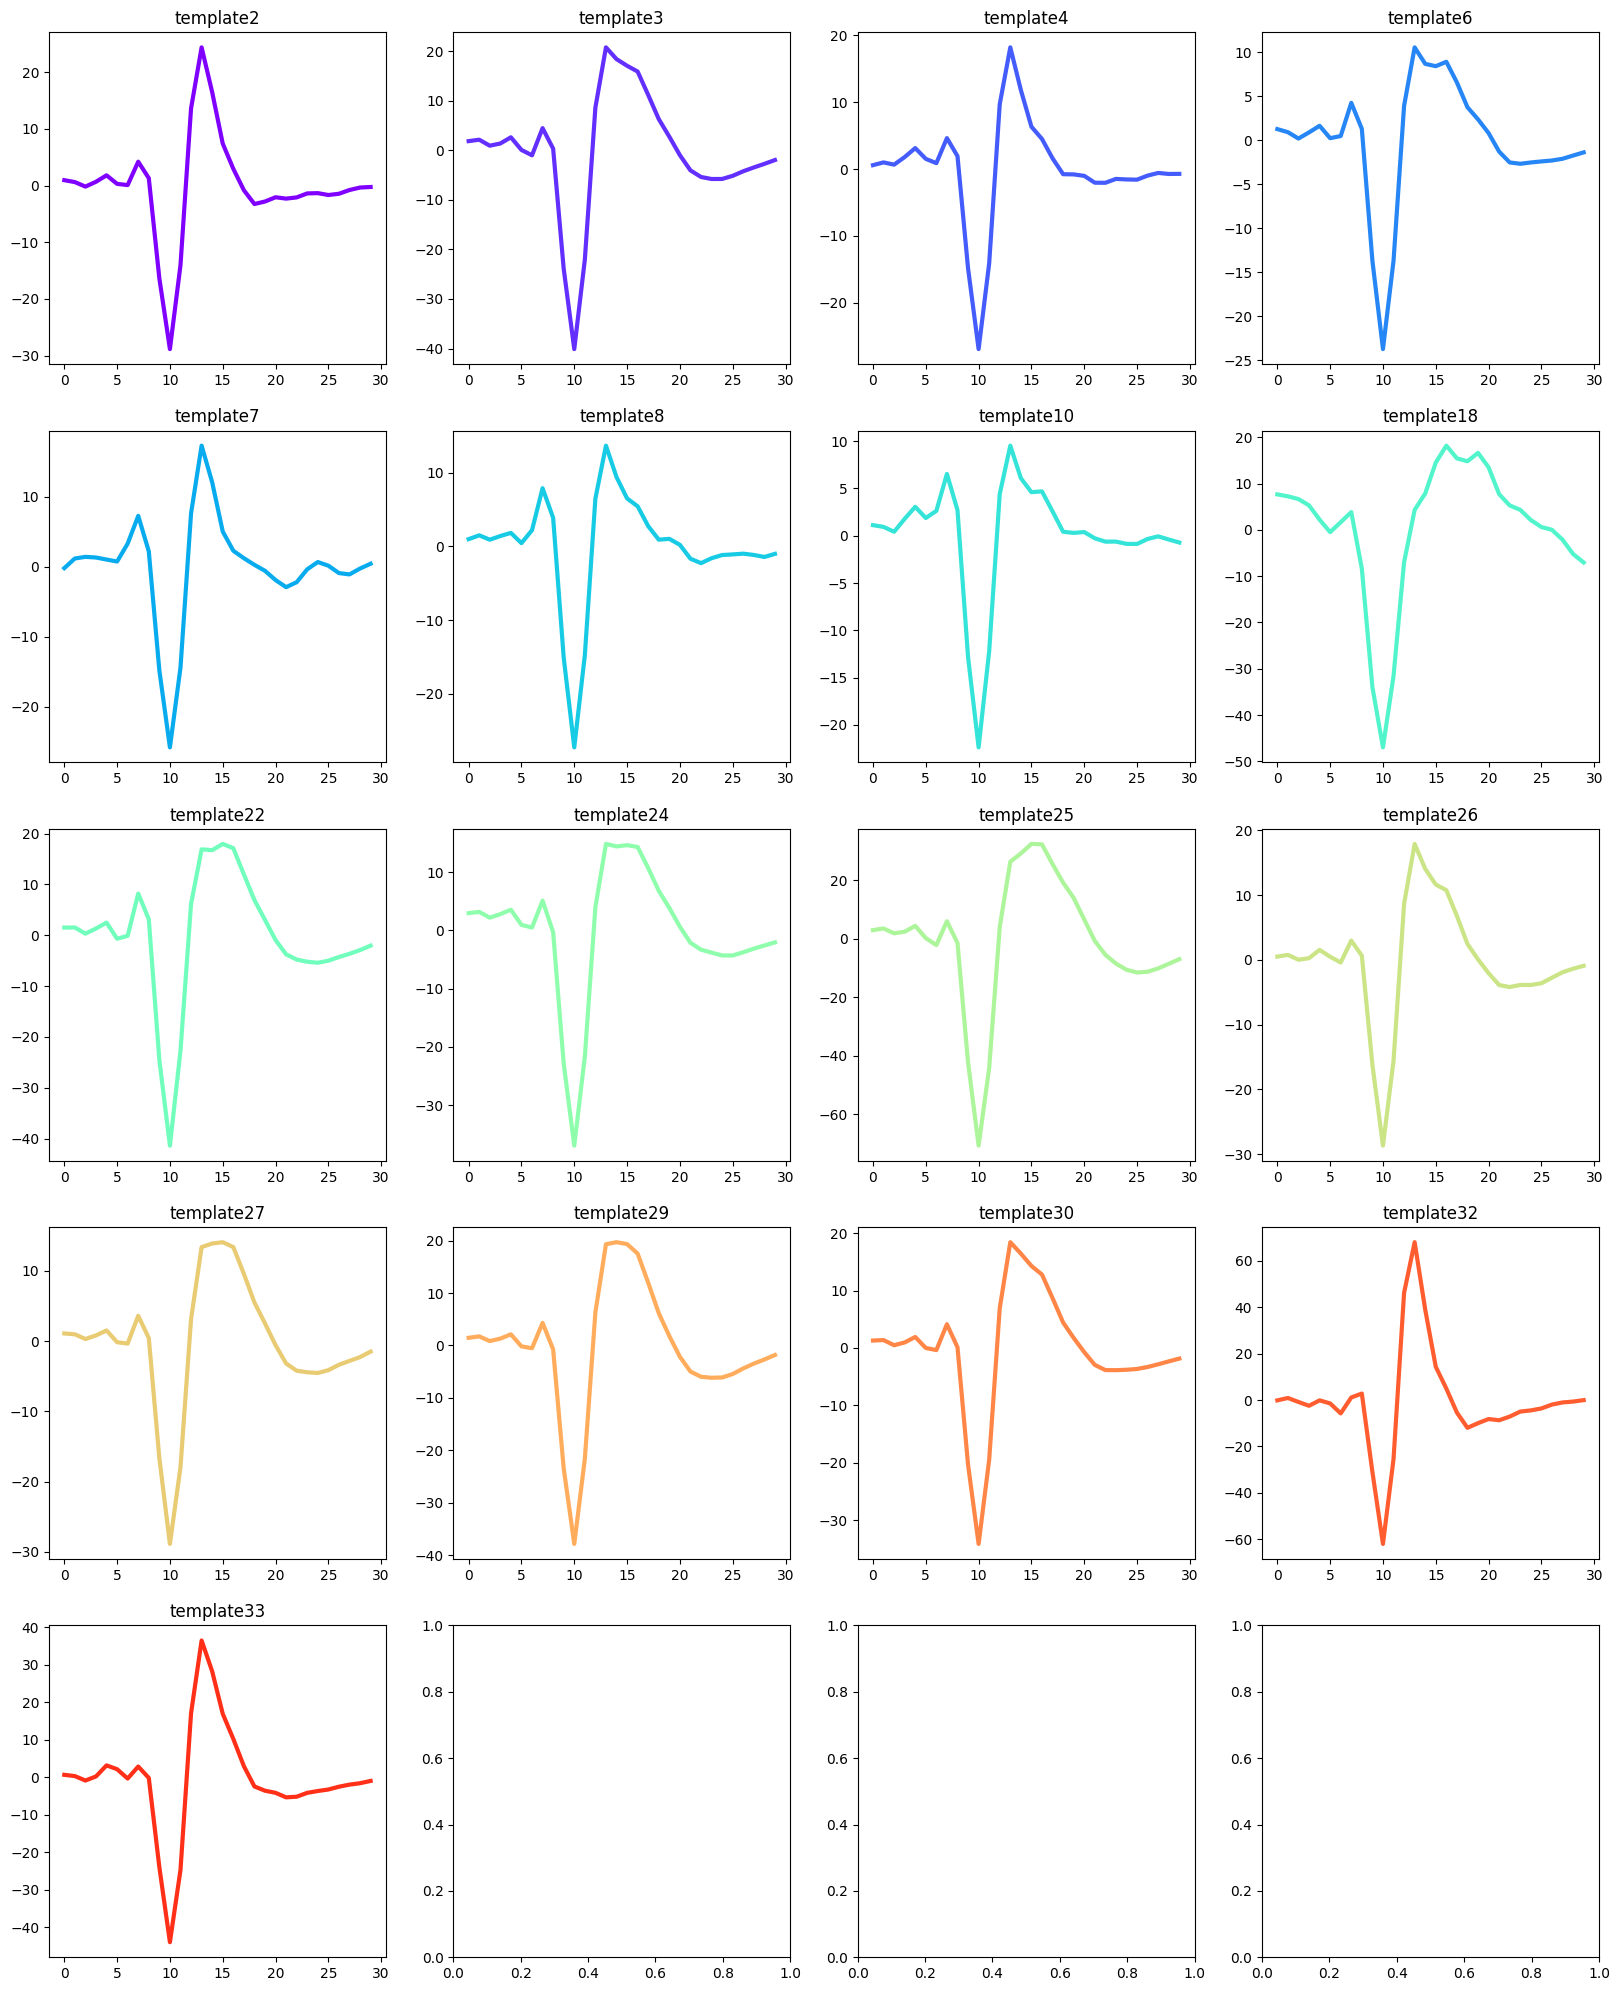

In [16]:
we._template_cache={}
sorting_unit_show(we, recording_cmr, sorting, pack_folder,waveform_folder)

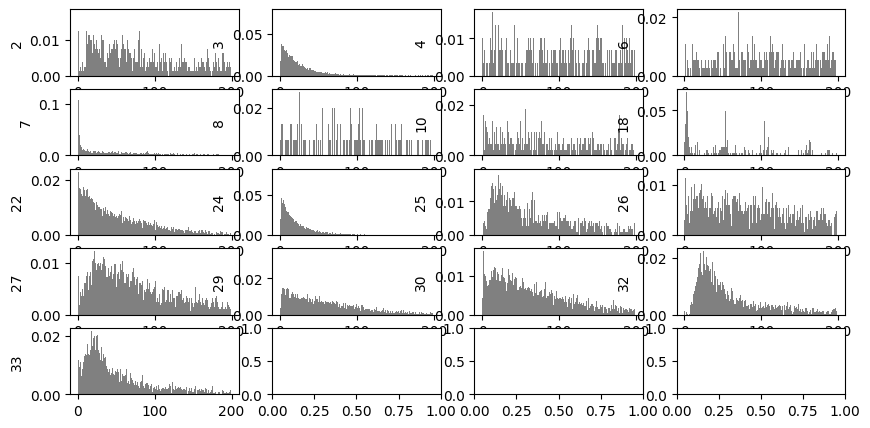

In [17]:

fig,ax = plt.subplots(int(ceil(sorting.unit_ids.shape[0]/4)),4,figsize=(10,5))
sw.plot_isi_distribution(sorting, window_ms=200.0, bin_ms=1.0,axes=ax)


Now, we can reformat information of sorted spikes as input for AutoSort

In [18]:
save_pth = './AutoSort_data/'
day_pth = './processed_data/'
raw_data_path = './raw_data/'

freq_max=3000
freq_min=300

left_sample=10
right_sample=20


In [19]:
generate_autosort_input(date_id_all,
                            raw_data_path,
                            save_pth,
                            day_pth,
                            left_sample,
                            right_sample,
                            freq_min,
                            freq_max,
                            mesh_probe
                            )

write_binary_recording with n_jobs = 1 and chunk_size = None
BinaryFolderRecording: 30 channels - 1 segments - 10.0kHz - 158.182s
Num. channels = 30
Sampling frequency = 10000 Hz
Num. timepoints seg0= 1
write_binary_recording with n_jobs = 1 and chunk_size = None
BinaryFolderRecording: 30 channels - 1 segments - 10.0kHz - 241.203s
Num. channels = 30
Sampling frequency = 10000 Hz
Num. timepoints seg0= 1
### 0305
### 1. load raw data
### 2. detect spikes
### 3. load ground truth


100%|██████████| 16/16 [00:00<00:00, 8270.75it/s]

### 4. map ground truth annotation


---spike detection rate: 0.9797192935330065
### 4.5 add all gt
### 5. find corresponding waveform


100%|██████████| 30/30 [00:07<00:00,  4.17it/s]


### 6. save output
### 7. find corresponding waveform


100%|██████████| 30/30 [00:07<00:00,  4.14it/s]


### 8. save output
### 0310
### 1. load raw data
### 2. detect spikes
### 3. load ground truth


100%|██████████| 16/16 [00:00<00:00, 9384.54it/s]

### 4. map ground truth annotation


---spike detection rate: 0.98716370669949
### 4.5 add all gt
### 5. find corresponding waveform


100%|██████████| 30/30 [00:09<00:00,  3.04it/s]


### 6. save output
### 7. find corresponding waveform


100%|██████████| 30/30 [00:09<00:00,  3.07it/s]


### 8. save output


The input to AutoSort is under the folder './AutoSort_data/'

### Train a AutoSort model.

In [21]:
### group ID of each electrode 1,2,3...
electrode_group=[1, 1, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1]
electrode_position=np.hstack([positions,np.array(electrode_group).reshape(-1,1)])

Set parameters of AutoSort

In [22]:
args=config()
args.day_id_str=date_id_all ### all days
args.cluster_path='./AutoSort_data/' ### path of input data
args.set_time=0  ### set 0305 data as training data
args.test_time=[1] ### set 0310 data as testing data
args.group=np.arange(30)  ### all electrodes
args.samplepoints=left_sample+right_sample ### 30 points for each waveform
args.sensor_positions_all=electrode_position

In [23]:
run(args)

---------------------------------- SEED ALL ---------------------------------- 
                           Seed Num :   0                                
---------------------------------- SEED ALL ---------------------------------- 
pred_location (139245, 3)
epoch : 1/20


100%|██████████| 218/218 [00:09<00:00, 23.59it/s]


epoch : 1/20, loss 1 = 0.000000, loss 2 = 330.640511,, loss 3 = 740.988600


100%|██████████| 55/55 [00:00<00:00, 66.18it/s]


epoch : 1/20, val loss 1 = 0.000000, loss 2 = 4.114871,loss 3 = 9.640091
Validation Loss Decreased(inf--->13.754963) 	 Saving The Model
epoch : 2/20


100%|██████████| 218/218 [00:03<00:00, 58.81it/s]


epoch : 2/20, loss 1 = 0.000000, loss 2 = 193.178763,, loss 3 = 423.306925


100%|██████████| 55/55 [00:00<00:00, 85.66it/s]


epoch : 2/20, val loss 1 = 0.000000, loss 2 = 2.847722,loss 3 = 6.419589
Validation Loss Decreased(13.754963--->9.267310) 	 Saving The Model
epoch : 3/20


100%|██████████| 218/218 [00:03<00:00, 58.07it/s]


epoch : 3/20, loss 1 = 0.000000, loss 2 = 143.481579,, loss 3 = 278.339883


100%|██████████| 55/55 [00:00<00:00, 80.82it/s]


epoch : 3/20, val loss 1 = 0.000000, loss 2 = 2.507965,loss 3 = 4.465588
Validation Loss Decreased(9.267310--->6.973553) 	 Saving The Model
epoch : 4/20


100%|██████████| 218/218 [00:03<00:00, 57.30it/s]


epoch : 4/20, loss 1 = 0.000000, loss 2 = 111.616244,, loss 3 = 191.615472


100%|██████████| 55/55 [00:00<00:00, 84.30it/s]


epoch : 4/20, val loss 1 = 0.000000, loss 2 = 2.090885,loss 3 = 3.172255
Validation Loss Decreased(6.973553--->5.263139) 	 Saving The Model
epoch : 5/20


100%|██████████| 218/218 [00:03<00:00, 58.01it/s]


epoch : 5/20, loss 1 = 0.000000, loss 2 = 84.410176,, loss 3 = 135.986480


100%|██████████| 55/55 [00:00<00:00, 83.64it/s]


epoch : 5/20, val loss 1 = 0.000000, loss 2 = 2.073249,loss 3 = 2.364286
Validation Loss Decreased(5.263139--->4.437535) 	 Saving The Model
epoch : 6/20


100%|██████████| 218/218 [00:03<00:00, 58.10it/s]


epoch : 6/20, loss 1 = 0.000000, loss 2 = 64.752462,, loss 3 = 100.513181


100%|██████████| 55/55 [00:00<00:00, 84.60it/s]


epoch : 6/20, val loss 1 = 0.000000, loss 2 = 1.785286,loss 3 = 1.800739
Validation Loss Decreased(4.437535--->3.586025) 	 Saving The Model
epoch : 7/20


100%|██████████| 218/218 [00:03<00:00, 57.45it/s]


epoch : 7/20, loss 1 = 0.000000, loss 2 = 48.028065,, loss 3 = 75.402992


100%|██████████| 55/55 [00:00<00:00, 84.74it/s]


epoch : 7/20, val loss 1 = 0.000000, loss 2 = 2.365495,loss 3 = 1.395947
epoch : 8/20


100%|██████████| 218/218 [00:03<00:00, 58.42it/s]


epoch : 8/20, loss 1 = 0.000000, loss 2 = 36.942173,, loss 3 = 59.012671


100%|██████████| 55/55 [00:00<00:00, 84.06it/s]


epoch : 8/20, val loss 1 = 0.000000, loss 2 = 3.124771,loss 3 = 1.103077
epoch : 9/20


100%|██████████| 218/218 [00:03<00:00, 58.74it/s]


epoch : 9/20, loss 1 = 0.000000, loss 2 = 28.823177,, loss 3 = 46.371493


100%|██████████| 55/55 [00:00<00:00, 85.58it/s]


epoch : 9/20, val loss 1 = 0.000000, loss 2 = 2.048367,loss 3 = 0.906828
Validation Loss Decreased(3.586025--->2.955195) 	 Saving The Model
epoch : 10/20


100%|██████████| 218/218 [00:03<00:00, 57.09it/s]


epoch : 10/20, loss 1 = 0.000000, loss 2 = 22.871423,, loss 3 = 37.524615


100%|██████████| 55/55 [00:00<00:00, 85.60it/s]


epoch : 10/20, val loss 1 = 0.000000, loss 2 = 3.207553,loss 3 = 0.789877
epoch : 11/20


100%|██████████| 218/218 [00:03<00:00, 58.54it/s]


epoch : 11/20, loss 1 = 0.000000, loss 2 = 17.747776,, loss 3 = 31.112469


100%|██████████| 55/55 [00:00<00:00, 85.87it/s]


epoch : 11/20, val loss 1 = 0.000000, loss 2 = 3.440332,loss 3 = 0.664548
epoch : 12/20


100%|██████████| 218/218 [00:03<00:00, 58.06it/s]


epoch : 12/20, loss 1 = 0.000000, loss 2 = 15.388322,, loss 3 = 26.073921


100%|██████████| 55/55 [00:01<00:00, 45.63it/s]


epoch : 12/20, val loss 1 = 0.000000, loss 2 = 2.443036,loss 3 = 0.541770
epoch : 13/20


100%|██████████| 218/218 [00:06<00:00, 33.17it/s]


epoch : 13/20, loss 1 = 0.000000, loss 2 = 15.040105,, loss 3 = 20.390552


100%|██████████| 55/55 [00:00<00:00, 79.12it/s]


epoch : 13/20, val loss 1 = 0.000000, loss 2 = 2.879471,loss 3 = 0.528056
epoch : 14/20


100%|██████████| 218/218 [00:04<00:00, 45.45it/s]


epoch : 14/20, loss 1 = 0.000000, loss 2 = 14.558989,, loss 3 = 16.567875


100%|██████████| 55/55 [00:00<00:00, 82.36it/s]


epoch : 14/20, val loss 1 = 0.000000, loss 2 = 3.033507,loss 3 = 0.477917
epoch : 15/20


100%|██████████| 218/218 [00:03<00:00, 57.26it/s]


epoch : 15/20, loss 1 = 0.000000, loss 2 = 11.740852,, loss 3 = 15.012247


100%|██████████| 55/55 [00:00<00:00, 80.93it/s]


epoch : 15/20, val loss 1 = 0.000000, loss 2 = 3.372676,loss 3 = 0.360178
epoch : 16/20


100%|██████████| 218/218 [00:03<00:00, 57.89it/s]


epoch : 16/20, loss 1 = 0.000000, loss 2 = 11.570271,, loss 3 = 12.874262


100%|██████████| 55/55 [00:00<00:00, 85.54it/s]


epoch : 16/20, val loss 1 = 0.000000, loss 2 = 2.838299,loss 3 = 0.376539
epoch : 17/20


100%|██████████| 218/218 [00:09<00:00, 23.30it/s]


epoch : 17/20, loss 1 = 0.000000, loss 2 = 11.579632,, loss 3 = 10.456739


100%|██████████| 55/55 [00:02<00:00, 18.61it/s]


epoch : 17/20, val loss 1 = 0.000000, loss 2 = 4.333641,loss 3 = 0.337019
epoch : 18/20


100%|██████████| 218/218 [00:12<00:00, 18.14it/s]


epoch : 18/20, loss 1 = 0.000000, loss 2 = 9.196238,, loss 3 = 9.392744


100%|██████████| 55/55 [00:01<00:00, 52.27it/s]


epoch : 18/20, val loss 1 = 0.000000, loss 2 = 3.623895,loss 3 = 0.315759
epoch : 19/20


100%|██████████| 218/218 [00:09<00:00, 23.35it/s]


epoch : 19/20, loss 1 = 0.000000, loss 2 = 10.644902,, loss 3 = 8.946619


100%|██████████| 55/55 [00:01<00:00, 30.24it/s]


epoch : 19/20, val loss 1 = 0.000000, loss 2 = 1.640556,loss 3 = 0.290822
Validation Loss Decreased(2.955195--->1.931378) 	 Saving The Model
epoch : 20/20


100%|██████████| 218/218 [00:05<00:00, 36.85it/s]


epoch : 20/20, loss 1 = 0.000000, loss 2 = 13.910450,, loss 3 = 7.684290


100%|██████████| 55/55 [00:00<00:00, 84.45it/s]


epoch : 20/20, val loss 1 = 0.000000, loss 2 = 2.211047,loss 3 = 0.447237
pred_location (138641, 3)


100%|██████████| 271/271 [00:03<00:00, 81.89it/s]


The trained model is saved in './AutoSort_data/model_save/train_day0305_0/train_weight'.

We will load it for spike sorting of later-stage recordings.

We read the training and testing log to check results.

In [27]:
training_log=pd.read_csv('/n/holystore01/LABS/jialiu_lab/Users/yichunhe/AutoSort/AutoSort_data/model_save/train_day0305_0/train_weight/training_log.csv',
index_col=0)

test_log=pd.read_csv('/n/holystore01/LABS/jialiu_lab/Users/yichunhe/AutoSort/AutoSort_data/model_save/train_day0305_0/train_weight/test_log.csv',
index_col=0)

In [28]:
training_log

,epoch,validation_acc_noise,validation_acc_label
0,1,0.894969,0.933277
1,2,0.932134,0.966554
2,3,0.939280,0.972466
3,4,0.942619,0.977872
4,5,0.947036,0.976689
5,6,0.945097,0.979223
6,7,0.943625,0.980743
7,8,0.949837,0.984291
8,9,0.947574,0.982095
9,10,0.950124,0.983953


In [29]:
test_log

,train_time,timepoint,noise_acc,label_acc
0,305,310,0.985848,0.997155
